In [1]:
import os, sys; sys.path.append(os.path.dirname(os.getcwd())); ROOT_DIR = '/home/h4zzkr/lab/delOS/backend'

In [21]:
dataset_path = os.path.join(ROOT_DIR, 'data/nlu_data/custom')

# Imports

In [18]:
import pandas as pd
import numpy as np
import tensorflow as tf
from pathlib import Path

from transformers import BertTokenizer
from transformers import TFBertModel

model_name = "bert-base-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)

In [22]:
df_train = pd.read_csv(os.path.join(dataset_path, 'train.csv'))
df_valid = pd.read_csv(os.path.join(dataset_path, 'valid.csv'))
df_train

,intent_label,words,word_labels,length
0,turnLightOn,enable light in the bedroom,O O O O B-location:room,5
1,turnLightOn,the light has to be on first,O O O O O O O,7
2,turnLightOn,make some light in bathroom,O O O O B-location:room,5
3,turnLightOff,no lights on in the office,O O O O O B-location:room,6
4,turnLightOff,turn off the light,O O O O,4
5,turnLightOn,enable electric lights inside the office,O O O O O B-location:room,6
6,turnLightOff,turn off the house lights out in the attic,O O O O O O O O B-location:room,9
7,turnLightOff,turn off lights in kitchen and basement,O O O O B-location:room O B-location:room,7
8,turnLightOn,also enable lights within the lavatory,O O O O O B-location:room,6
9,turnLightOff,"hey , shutdown the lights",O O O O O,5


In [12]:
df_train.groupby("intent_label").count()

,words,word_labels,length
intent_label,,,
turnLightOff,23,23,23
turnLightOn,18,18,18


In [24]:
first_sentence = df_train.iloc[0]["words"]
first_sentence, tokenizer.encode(first_sentence), tokenizer.decode(tokenizer.encode(first_sentence))

('enable light in the bedroom',
 [101, 9396, 1609, 1107, 1103, 4255, 102],
 '[CLS] enable light in the bedroom [SEP]')

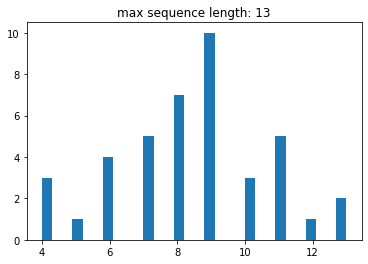

In [25]:
import matplotlib.pyplot as plt

train_sequence_lengths = [len(tokenizer.encode(text))
                          for text in df_train["words"]]
plt.hist(train_sequence_lengths, bins=30)
plt.title(f"max sequence length: {max(train_sequence_lengths)}");
max_seq_len = max(train_sequence_lengths)

In [29]:
import numpy as np


def encode_dataset(tokenizer, text_sequences, max_length):
    token_ids = np.zeros(shape=(len(text_sequences), max_length),
                         dtype=np.int32)
    for i, text_sequence in enumerate(text_sequences):
        encoded = tokenizer.encode(text_sequence)
        token_ids[i, 0:len(encoded)] = encoded
    attention_masks = (token_ids != 0).astype(np.int32)
    return {"input_ids": token_ids, "attention_masks": attention_masks}


encoded_train = encode_dataset(tokenizer, df_train["words"], max_seq_len + 2)
encoded_valid = encode_dataset(tokenizer, df_valid["words"], max_seq_len + 2)

In [35]:
intent_names = Path(os.path.join(dataset_path, "vocab.intent")).read_text().split()
intent_map = dict((label, idx) for idx, label in enumerate(intent_names))
intent_map

{'turnLightOff': 0, 'turnLightOn': 1}

In [36]:
intent_train = df_train["intent_label"].map(intent_map).values
intent_valid = df_valid["intent_label"].map(intent_map).values

In [31]:
intent_names = Path(os.path.join(dataset_path, "vocab.intent")).read_text().split()
intent_map = dict((label, idx) for idx, label in enumerate(intent_names))
intent_map

{'turnLightOff': 0, 'turnLightOn': 1}

# Model

In [41]:
import tensorflow as tf
from transformers import TFBertModel
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.activations import softmax

In [33]:
base_bert_model = TFBertModel.from_pretrained("bert-base-cased")
base_bert_model.summary()

Some weights of the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "tf_bert_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  108310272 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


In [76]:
class IntentClassificationModel(tf.keras.Model):

    def __init__(self, intent_num_labels=None, model_name="bert-base-cased",
                 dropout_prob=0.1):
        super().__init__(name="joint_intent_slot")
        self.bert = TFBertModel.from_pretrained(model_name)
        self.bert.trainable = False
        self.dropout = Dropout(dropout_prob)
        self.intent_classifier = Dense(intent_num_labels)

    def call(self, inputs, **kwargs):
        sequence_output, sentence_emb = self.bert(inputs, **kwargs)
        sentence_emb = self.dropout(sentence_emb,training=kwargs.get("training", False))
        intent_logits = self.intent_classifier(sentence_emb)
        out = softmax(intent_logits)
        return out


intent_model = IntentClassificationModel(intent_num_labels=len(intent_map))

Some weights of the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertModel for predictions without further training.


In [58]:
optim = Adam(learning_rate=0.001, epsilon=1e-08)
loss_f = SparseCategoricalCrossentropy(from_logits=False)
metrics_f = [SparseCategoricalAccuracy('accuracy')]

In [59]:
intent_model.compile(optimizer=optim,
                     loss=loss_f,
                     metrics=metrics_f
                    )

In [75]:
history = intent_model.fit(encoded_train, intent_train, epochs=4, batch_size=16,
                           validation_data=(encoded_valid, intent_valid))

Epoch 1/4
3/3 [==============================] - 0s 51ms/step - loss: 0.7534 - accuracy: 0.4878 - val_loss: 0.6543 - val_accuracy: 0.6364
Epoch 2/4
3/3 [==============================] - 0s 52ms/step - loss: 0.6416 - accuracy: 0.6341 - val_loss: 0.6159 - val_accuracy: 0.7273
Epoch 3/4
3/3 [==============================] - 0s 60ms/step - loss: 0.6264 - accuracy: 0.6585 - val_loss: 0.7019 - val_accuracy: 0.5455
Epoch 4/4
3/3 [==============================] - 0s 58ms/step - loss: 0.6196 - accuracy: 0.7073 - val_loss: 0.8687 - val_accuracy: 0.2727


# ELse

In [78]:
!pip install sklearn

     |████████████████████████████████| 6.8 MB 5.6 MB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1315 sha256=9689e09e81ea72b1d1793fa26c4252a3481f1587f6f49fd00ce965a5ee31b3c9
  Stored in directory: /home/h4zzkr/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn


In [152]:
class Encoder(tf.keras.Model):
    def __init__(self, model_name="bert-base-cased"):
        super().__init__(name="")
        self.bert = TFBertModel.from_pretrained(model_name)

    def call(self, inputs, **kwargs):
        sequence_output, sentence_emb = self.bert(inputs, **kwargs)
        return sentence_emb
    
class EncoderText(tf.keras.Model):
    def __init__(self, model_name="bert-base-cased"):
        super().__init__(name="")
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.bert = TFBertModel.from_pretrained(model_name)

    def call(self, inputs, **kwargs):
        inputs = tf.constant(self.tokenizer.encode(inp))[None, :]
        sequence_output, sentence_emb = self.bert(inputs, **kwargs)
        return sentence_emb

encoder = Encoder()
encodertext = EncoderText()

Some weights of the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertModel for predictions without further training.
Some weights of the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializ

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [93]:
en_train = encoder(encoded_train)
en_valid = encoder(encoded_valid)

In [90]:
en_train.shape, intent_train.shape

(TensorShape([41, 768]), (41,))

In [32]:
from sklearn.metrics import accuracy_score

def accuracy(model, y_true, valid_data):
    y_pred = np.argmax(model.predict_proba(valid_data), axis=1)
    return accuracy_score(y_true, y_pred)

In [40]:
m = LogisticRegression(
    penalty='l2',
    C=1,
    solver='liblinear',
    max_iter=2,
)
m.fit(train, intent_train)

/home/h4zzkr/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=1, max_iter=2, solver='liblinear')

In [42]:
accuracy(m, intent_valid, valid)

0.9090909090909091

In [43]:
id2intent = {intent_map[k] : k for k in intent_map.keys()}

In [49]:
def test_output(inp, featurizer, model, intents_map):
    inp = featurizer.encode(inp)
    pred = np.argmax(model.predict_proba(inp), axis=1)[0]
    return intents_map[pred]
inp = 'disable the lights'
test_output(inp, featurizer, m, id2intent)

'turnLightOff'

In [180]:
i1 = 'turn on lights'
i2 = 'turn on lights'
i1emb = np.array(encodertext(i1))
i2emb = np.array(encodertext(i2))

# A

In [ ]:
from sentence_transformers import SentenceTransformer
featurizer = SentenceTransformer('bert-large-nli-mean-tokens')

 45%|████▌     | 560M/1.24G [07:35<13:26, 848kB/s]  

In [13]:
i1 = 'turn on ights'
i2 = 'disable lights'
emb1, emb2 = featurizer.encode(i1), featurizer.encode(i2)

In [14]:
from sklearn.metrics.pairwise import cosine_similarity

In [15]:
cosine_similarity(emb1, emb2)

array([[0.7306787]], dtype=float32)